In [42]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from gymnasium.utils.env_checker import check_env
from IPython.display import Video
from enum import Enum, auto

from flygym.mujoco import Parameters
from flygym.mujoco.arena import FlatTerrain
from flygym.mujoco.examples.obstacle_arena import ObstacleOdorArena
from flygym.mujoco.examples.turning_controller import HybridTurningNMF

# added by shu 
from scipy.signal import find_peaks
import pickle
from scipy.interpolate import interp1d


In [55]:
import flygym.mujoco
from tqdm import trange

# We start by creating a simple arena
flat_terrain_arena = FlatTerrain()

# Then, we add visual and olfactory features on top of it
arena = ObstacleOdorArena(
    terrain=flat_terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (12.5, 5), (17.5, -5)]),
    marker_size=0.5,
    obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.2, 0.8, 0.2, 1), (0.2, 0.2, 0.8, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
)

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

run_time = 2
sim_params = flygym.mujoco.Parameters(
    timestep=1e-4, 
    render_mode="saved", 
    render_playspeed=0.1, 
    draw_contacts=False,
    render_camera="Animat/camera_top"
)

nmf = HybridTurningNMF(
    sim_params=sim_params,
    init_pose="stretch",
    ############## 0.5 default of the Neuromechfly (0.2 for the TurningController)
    spawn_pos=(10, -5, 0.5),
    spawn_orientation=(0, 0, np.pi / 2 + np.deg2rad(80)),
    ###############
    contact_sensor_placements=contact_sensor_placements,
    arena=arena
)


In [46]:
# code from the exercise session --> backward movement of the fly
# just need to run it to get the data_block_backwards

# run_time = 2
# sim_params = flygym.mujoco.Parameters(
#     timestep=1e-4, render_mode="saved", render_playspeed=0.2, draw_contacts=True
# )
actuated_joints = flygym.mujoco.preprogrammed.all_leg_dofs

data_path = flygym.common.get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

target_num_steps = int(run_time / sim_params.timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * sim_params.timestep
for i, dof in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[dof])

# get the joint angle of the right hind leg tibia
rh_tibia_angle = data_block[actuated_joints.index("joint_RHTibia")]

# ===============================================================================================
# TODO: detect peaks in the tibia angle of the right hind leg using scipy.signal.find_peaks
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html for usage
peak_frame_indices = find_peaks(rh_tibia_angle)[0]
# ===============================================================================================

cycle_n_frames = round(np.diff(peak_frame_indices).mean())

data_block_cycle = np.zeros((len(actuated_joints), cycle_n_frames))

for a, b in np.lib.stride_tricks.sliding_window_view(peak_frame_indices, 2):
    old_indices = np.arange(b - a)
    new_indices = np.linspace(0, old_indices.max(), cycle_n_frames)
    data_block_cycle += interp1d(old_indices, data_block[:, a:b])(new_indices)

data_block_cycle /= len(peak_frame_indices) - 1

data_block_backwards = data_block_cycle.copy()
# data_block_backwards = data_block_backwards[:, ::-1]  # reverse the order of the frames

for i, (dof, angles) in enumerate(zip(actuated_joints, data_block_cycle)):
    # reassign the joint angles
    # (LF -> RH, RF -> LH, LM -> RM, RM -> LM, LH -> RF, RH -> LF)
    orig_dof = dof.translate(str.maketrans("LRFH", "RLHF"))[:8] + dof[8:]
    orig_angles = data_block_cycle[actuated_joints.index(orig_dof)]
    # rescale to match the range of the joint angles of that leg
    data_block_backwards[i] = (
        orig_angles - orig_angles.min()
    ) / orig_angles.ptp() * angles.ptp() + angles.min()

# sim_params = flygym.mujoco.Parameters(
#     timestep=1e-4, 
#     render_mode="saved", 
#     render_playspeed=0.1, 
#     draw_contacts=False,
# )

In [69]:
from enum import Enum, auto

# Random State Seed for Reproducibility (On the same machine)
seed = 1

# Definition of the states of the FSM
class State(Enum):
    GO_STRAIGHT = 1
    TURN_LEFT = 2
    TURN_RIGHT = 3
    REVERSE = 4
    REACH_AND_TURN = 5

# Example of setting a current state
current_state = State.GO_STRAIGHT
next_state = State.GO_STRAIGHT

decision_interval = 0.2
#run_time = 2
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)

# Low Force Threshold: Turn
low_force_thresh = 2
# High Force Threshold: Need to Reverse
high_force_thresh = 4


enforce_time = 0
turn_delay = 0.001
reverse_delay = 0.2

obs_hist = []
odor_history = []
obs, _ = nmf.reset(seed)
bias = np.array([0,0])

for i in trange(int(run_time / nmf.sim_params.timestep)):
    curr_time = i * nmf.sim_params.timestep
    # Front legs
    left_sense = np.array(obs["contact_forces"][:5, 0:2])
    right_sense = np.array(obs["contact_forces"][18:23, 0:2])
    left_sense_sum = np.abs(left_sense).sum()
    right_sense_sum = np.abs(right_sense).sum()
    # Middle legs
    left_sense_middle = np.array(obs["contact_forces"][6:11, 0:2])
    right_sense_middle = np.array(obs["contact_forces"][24:29, 0:2])
    left_sense_middle_sum = np.abs(left_sense_middle).sum()
    right_sense_middle_sum = np.abs(right_sense_middle).sum()

    orig = False


# Decision Making Process

    # (Default) State: Going Straight
    if current_state == State.GO_STRAIGHT:
        # Action: Go Straight
        control_signal = np.array([1, 1])
        # Using Unmodified Step Function (No Turning)
        orig = False

        # If High Force Detected on Both Sides
        # CHANGED OR TO AND#################
        # MAYBE WE NEED A STATE HERE THAT IS TURNING more VIGOUROUSLY?
        if right_sense_sum > high_force_thresh and left_sense_sum > high_force_thresh:
            print("High force detected on both sides")
            # Change State to Reverse
            current_state = State.REVERSE
            # Default Turning Direction for when both Sides experience High Force
            next_state = State.TURN_LEFT
            # Enforce Delay for Reversing
            enforce_time = curr_time + reverse_delay

        # If High Force only Detected on Left Side
        elif left_sense_sum > high_force_thresh or left_sense_middle_sum > high_force_thresh:
            print("High force detected on left side")
            current_state = State.REVERSE
            next_state = State.TURN_RIGHT
            enforce_time = curr_time + reverse_delay

        # If Low Force Detected on Left Side
        elif left_sense_sum > low_force_thresh or left_sense_middle_sum > low_force_thresh:
            print("Low force detected on left side")
            current_state = State.TURN_RIGHT
            enforce_time = curr_time + turn_delay

        # If High Force Detected only on Right Side
        elif right_sense_sum > high_force_thresh or right_sense_middle_sum > high_force_thresh:
            print("High force detected on right side")
            current_state = State.REVERSE
            next_state = State.TURN_LEFT
            enforce_time = curr_time + reverse_delay

        # If Low Force Detected on Right Side
        elif right_sense_sum > low_force_thresh or right_sense_middle_sum > low_force_thresh:
            print("Low force detected on right side")
            current_state = State.TURN_LEFT
            enforce_time = curr_time + turn_delay


    # State: Turning Right
    elif current_state == State.TURN_RIGHT:
        control_signal = np.array([1, 0])
        orig = False
        if left_sense_sum > high_force_thresh:
            current_state = State.REVERSE
            enforce_time = curr_time + reverse_delay
        elif right_sense_sum > low_force_thresh:
            current_state = State.REACH_AND_TURN
        elif left_sense_sum > low_force_thresh:
            enforce_time = curr_time + turn_delay
        elif curr_time >= enforce_time:
            current_state = State.GO_STRAIGHT

    # State: Turning Left        
    elif current_state == State.TURN_LEFT:
        control_signal = np.array([0, 1])
        orig = False
        if right_sense_sum > high_force_thresh:
            current_state = State.REVERSE
            enforce_time = curr_time + reverse_delay
        elif left_sense_sum > low_force_thresh:
            current_state = State.REACH_AND_TURN
        elif right_sense_sum > low_force_thresh:
            enforce_time = curr_time + turn_delay
        elif curr_time >= enforce_time:
            current_state = State.GO_STRAIGHT

    # State: Reversing       
    elif current_state == State.REVERSE:
        # control_signal = reverse_control_signal
        joint_pos = data_block_backwards[:, i % cycle_n_frames]
        control_signal = {"joints": joint_pos}
        orig = True
        #enforce_time = curr_time + reverse_delay
        
        if curr_time >= enforce_time:
            current_state = next_state
            
        #enforce_time = curr_time + reverse_delay   

    # State: Reach and Turn        
    elif current_state == State.REACH_AND_TURN:
        # control_signal = reach and turn control signal
        orig = True
        # keep reaching and turning
        # if free path is found
        #   go straight
        # trash=0
        control_signal = np.array([1, 1])


    #obs, reward, terminated, truncated, info = nmf.step(control_signal, orig)

    # Initial ignoring of the forces experienced by the fly's legs
    # When Fly is moved to initial position

    #if i > 1000:
    obs, reward, terminated, truncated, info = nmf.step(control_signal, orig)
    obs_hist.append(obs)
    nmf.render()
    
    #nmf.render()

nmf.save_video("./outputs/pillars.mp4")
Video("./outputs/pillars.mp4")

  0%|          | 0/20000 [00:00<?, ?it/s]

  4%|▎         | 700/20000 [00:03<01:13, 264.24it/s]

Low force detected on left side


  8%|▊         | 1501/20000 [00:06<00:57, 320.90it/s]

Low force detected on right side


 18%|█▊        | 3634/20000 [00:20<01:20, 202.86it/s]

Low force detected on left side


 19%|█▊        | 3708/20000 [00:21<01:15, 214.46it/s]

Low force detected on right side


 22%|██▏       | 4325/20000 [00:23<00:49, 316.67it/s]

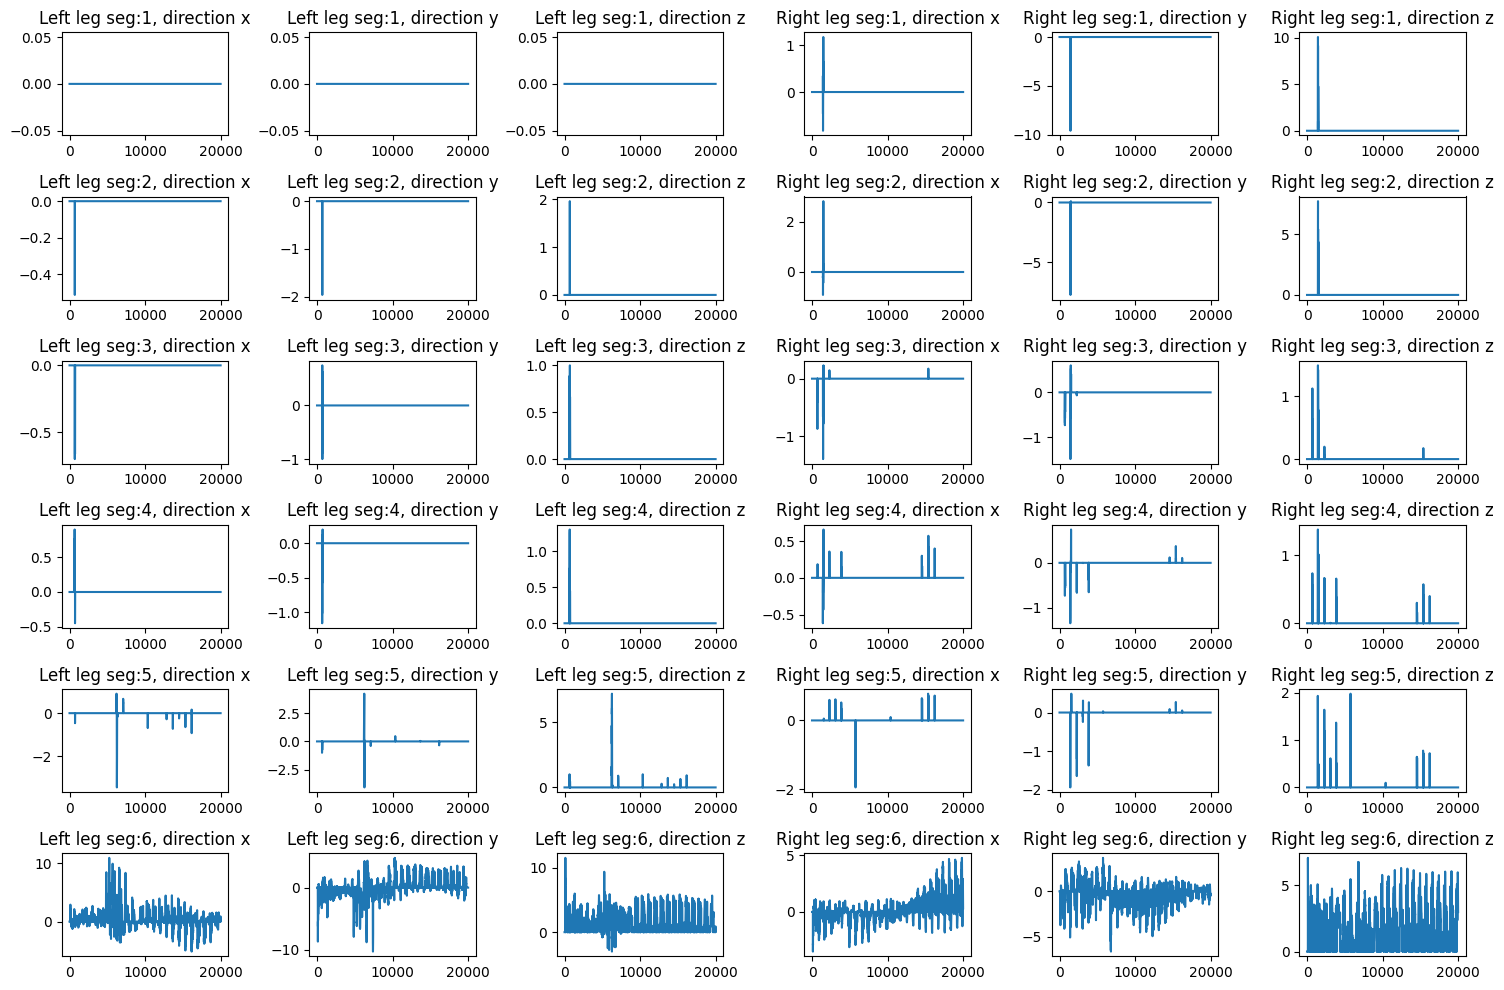

In [20]:
#FRONT LEGS
import numpy as np
import matplotlib.pyplot as plt

# Assuming obs_hist is your list of observations
forces_left = np.array([obs["contact_forces"][:6,:] for obs in obs_hist])
forces_right = np.array([obs["contact_forces"][18:24,:] for obs in obs_hist])

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(15, 10))

directions = ['x', 'y', 'z']


# For each segment
for i in range(6):
    # For each direction
    for j in range(3):
        # Left leg
        axs[i, j].plot(forces_left[:, i, j])
        axs[i, j].set_title(f'Left leg seg:{i+1}, direction {directions[j]}')
        
        # Right leg
        axs[i, j+3].plot(forces_right[:, i, j])
        axs[i, j+3].set_title(f'Right leg seg:{i+1}, direction {directions[j]}')

plt.tight_layout()
plt.show()

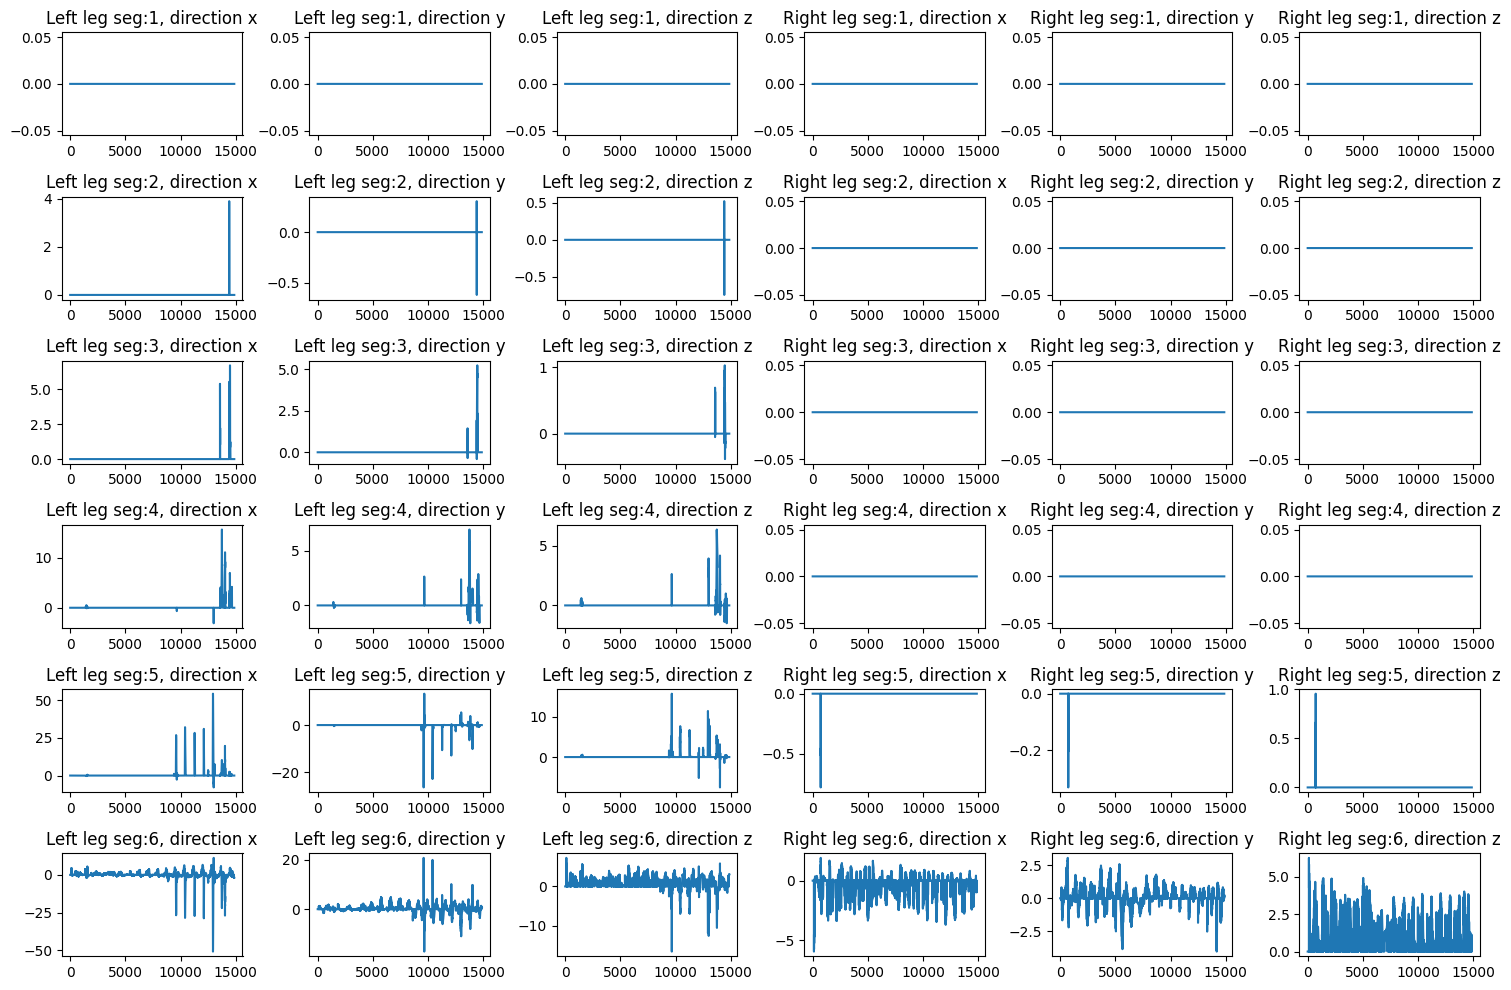

In [37]:
#MIDDLE LEGS

# Assuming obs_hist is your list of observations
forces_left = np.array([obs["contact_forces"][6:12,:] for obs in obs_hist])
forces_right = np.array([obs["contact_forces"][24:30,:] for obs in obs_hist])

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(15, 10))

directions = ['x', 'y', 'z']


# For each segment
for i in range(6):
    # For each direction
    for j in range(3):
        # Left leg
        axs[i, j].plot(forces_left[:, i, j])
        axs[i, j].set_title(f'Left leg seg:{i+1}, direction {directions[j]}')
        
        # Right leg
        axs[i, j+3].plot(forces_right[:, i, j])
        axs[i, j+3].set_title(f'Right leg seg:{i+1}, direction {directions[j]}')

plt.tight_layout()
plt.show()

In [29]:
non_zero_arrays = forces_left[np.any(forces_left != 0, axis=(1,2))]

# The first non-zero array
first_non_zero_array = non_zero_arrays[0]

In [31]:
# Get the index of the first non-zero array
index_first_non_zero_array = np.argmax(np.any(forces_left != 0, axis=(1,2)))
first_non_zero_array = forces_left[index_first_non_zero_array]

In [33]:
index_first_non_zero_array, first_non_zero_array

(108,
 array([[ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ],
        [ 1.4993544, -2.726335 ,  4.281176 ]], dtype=float32))

In [ ]:
for i in range(100):
    print(i)